### 导入图像分类数据集
fashion mnist

In [1]:
# 魔法命令，让图像行内显示
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import d2l

In [2]:
d2l.use_svg_display()

通过框架中的内置函数将Fashion-MNIST数据集下载并读取到内存中

In [3]:
# 通过ToTensor实例将图像数据从PIL类型变换为32位浮点数格式
# 然后除以255使得所有像素的数值均在0到1之间（归一化）
trans = transforms.ToTensor()
# 加载训练集
mnist_train = torchvision.datasets.FashionMNIST(root="./data", train=True,
                                                transform=trans, download=True)
# 加载测试集
mnist_test = torchvision.datasets.FashionMNIST(root="./data", train=False,
                                              transform=trans, download=True)

In [4]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [5]:
# 类别数据
print(mnist_train.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


展示图片，显示几个样本的图像及其对应的标签

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001773CD85A20>,
      dtype=object)

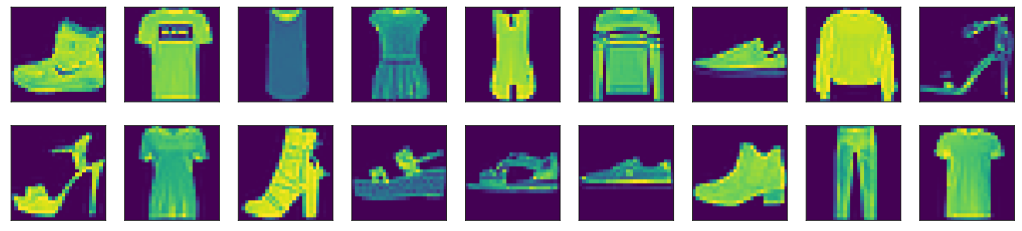

In [6]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
d2l.show_images(X.reshape(18, 28, 28), 2, 9)

读取一小批量数据，大小为`batch_size`

In [11]:
batch_size = 256

# 数据加载器
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4)

In [13]:
%%timeit
# 测试加载时间
# 这里有一个坑，魔法命令必须写在block的第一行
for X, y in train_iter:
    continue

3.03 s ± 80.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
help(d2l.load_data_fashion_mnist)

Help on function load_data_fashion_mnist in module d2l.utils:

load_data_fashion_mnist(batch_size, resize=None, root='~/Datasets/FashionMNIST')
    Download the fashion mnist dataset and then load into memory.



### 线性回归从零开始实现

In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import d2l

In [2]:
# 通过ToTensor实例将图像数据从PIL类型变换为32位浮点数格式
# 然后除以255使得所有像素的数值均在0到1之间（归一化）
trans = transforms.ToTensor()
# 加载训练集
mnist_train = torchvision.datasets.FashionMNIST(root="./data", train=True,
                                                transform=trans, download=True)
# 加载测试集
mnist_test = torchvision.datasets.FashionMNIST(root="./data", train=False,
                                              transform=trans, download=True)

In [3]:
batch_size = 256
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=1)
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=1)

In [4]:
# 10个类别
num_class = 10
# 输入维度
num_input = 784
# 初始化w, b
W = torch.normal(0, 0.01, [num_input, num_class], requires_grad=True)
b = torch.zeros([10], requires_grad=True)
W.shape, b.shape

(torch.Size([784, 10]), torch.Size([10]))

In [5]:
# softmax函数
def softmax(X):
    X_exp = torch.exp(X)
    partiton = X_exp.sum(1, keepdim=True)
    return X_exp/partiton

In [6]:
# 交叉熵损失
def cross_entropy_loss(y, label):
    return -torch.sum(torch.log(y[range(0,len(label)),label]))

In [7]:
lr = 0.001
epoch = 10
best_acc = 0

In [8]:
for i in range(epoch):
    total_loss = 0
    for num, data in enumerate(train_iter, start=1):
        img, label = data
        # 展平
        img = torch.flatten(img, start_dim=1)
        # Softmax回归（分类，先做线性回归，再经过softmax函数）
        y = torch.mm(img,W)+b
        loss = cross_entropy_loss(softmax(y), label)
        total_loss += loss
        avg_loss = total_loss/num
        loss.backward()
        # 梯度下降
        with torch.no_grad():
            W -= W.grad*lr
            W.grad.zero_()
            b -= b.grad*lr
            b.grad.zero_()

    
    for _, test in enumerate(test_iter, start=1):
        img, label = test
        # 展平
        img = torch.flatten(img, start_dim=1)
        y = torch.mm(img,W)+b
        predict = torch.argmax(y, dim=1)
        accuracy = float((predict == label).sum().item())/len(label)
        if accuracy > best_acc:
            best_acc = accuracy
    print('epoch: %d, accuracy: %.2f, avgLoss: %.2f' % (i, best_acc, avg_loss))

epoch: 0, accuracy: 0.88, avgLoss: 236.81
epoch: 1, accuracy: 0.88, avgLoss: 153.62
epoch: 2, accuracy: 0.88, avgLoss: 143.79
epoch: 3, accuracy: 0.90, avgLoss: 135.92
epoch: 4, accuracy: 0.90, avgLoss: 133.24
epoch: 5, accuracy: 0.90, avgLoss: 128.61
epoch: 6, accuracy: 0.91, avgLoss: 126.48
epoch: 7, accuracy: 0.91, avgLoss: 123.84
epoch: 8, accuracy: 0.91, avgLoss: 125.52
epoch: 9, accuracy: 0.91, avgLoss: 127.12


### 线性回归简洁实现

In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils import data
from torchvision import transforms

In [2]:
# 通过ToTensor实例将图像数据从PIL类型变换为32位浮点数格式
# 然后除以255使得所有像素的数值均在0到1之间（归一化）
trans = transforms.ToTensor()
# 加载训练集
mnist_train = torchvision.datasets.FashionMNIST(root="./data", train=True,
                                                transform=trans, download=True)
# 加载测试集
mnist_test = torchvision.datasets.FashionMNIST(root="./data", train=False,
                                              transform=trans, download=True)

In [3]:
# 准备数据
batch_size = 256
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=1)
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=1)

In [4]:
# 模型
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)
        
# loss
criterion = nn.CrossEntropyLoss()
# 优化器
optim = torch.optim.SGD(net.parameters(), 0.001)
epoch = 10
best_acc = 0

In [5]:
for i in range(epoch):
    # 训练
    net.train()
    for _, data in enumerate(train_iter):
        img, label = data
        # 清空梯度
        optim.zero_grad()
#         # 展平
#         img = torch.flatten(img, start_dim=1)
        # 推理
        output = net(img)
        # 计算loss
        loss = criterion(output, label)
        # 反向传播
        loss.backward()
        # 更新
        optim.step()
    # 评估
    net.eval()
    for _, test in enumerate(test_iter):
        img, label = test
#         # 展平
#         img = torch.flatten(img, start_dim=1)
        output = net(img)
        # 标签
        predict = torch.argmax(output, dim=1)
        accuracy = float((predict == label).sum().item())/len(label)
        if accuracy > best_acc:
            best_acc = accuracy
    print('epoch: %d, accuracy: %.2f, Loss: %.2f' % (i, best_acc, loss))

epoch: 0, accuracy: 0.70, Loss: 1.89
epoch: 1, accuracy: 0.74, Loss: 1.66
epoch: 2, accuracy: 0.75, Loss: 1.47
epoch: 3, accuracy: 0.75, Loss: 1.39
epoch: 4, accuracy: 0.76, Loss: 1.26
epoch: 5, accuracy: 0.76, Loss: 1.31
epoch: 6, accuracy: 0.76, Loss: 1.19
epoch: 7, accuracy: 0.77, Loss: 1.12
epoch: 8, accuracy: 0.79, Loss: 1.06
epoch: 9, accuracy: 0.79, Loss: 0.99
